<a href="https://colab.research.google.com/github/Tclack88/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sb
import matplotlib.pyplot as plt

In [109]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data",
                          names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'])
df = df.replace({'n':0,'y':1,'?':np.nan})
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
dem = df[df.party=='democrat']
rep = df[df.party=='republican']

In [0]:
def confidence_interval(data,confidence=.95):
  data = data.dropna()
  #data = np.array(data)
  n = len(data)
  t = stats.t.ppf((1+confidence)/2,n-1)
  stderr = data.std()/np.sqrt(n) # using pandas because std assumes sample std by default
  margin_of_error = t*stderr
  mean = data.mean()
  print('Margin of Error:',margin_of_error)
  return mean, mean - margin_of_error, mean + margin_of_error

### Mean Democratic vote for "Handicaped Infants" issue:

In [112]:
CI = confidence_interval(dem['handicapped-infants'])
CI

Margin of Error: 0.06005846304814615


(0.6046511627906976, 0.5445926997425515, 0.6647096258388437)

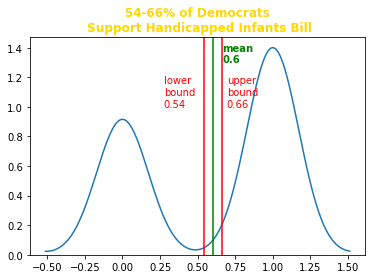

In [113]:
# for i,issue in enumerate(issues):     # use for multiple plots (stretch goal)
#   plt.figure(i)
#   sb.kdeplot(dem[issue].dropna());   

sb.kdeplot(dem['handicapped-infants'].dropna(),legend=False)
plt.axvline(CI[0],color='green')
plt.axvline(CI[1],color='red')
plt.axvline(CI[2],color='red')
plt.annotate(xy=(CI[1]-.27,1),s='lower\nbound\n'+str(round(CI[1],2)),color='r')
plt.annotate(xy=(CI[2]+.03,1),s='upper\nbound\n'+str(round(CI[2],2)),color='r')
plt.annotate(xy=(CI[2],1.3),s='mean\n'+str(round(CI[0],2)),color='g',fontweight='bold')


plt.title('54-66% of Democrats\n Support Handicapped Infants Bill',
          color='gold',fontweight='bold');
  

#### Conclusion
From this sample, we can conclude that 60.5% of democrats would vote in favor of this bill with a 95% confidence interval (54.5% to 66.5%), or 6% margin of error

In [0]:
issues = list(df.columns[1:])

## Chi-squared Tests

### 'By Hand' using Numpy and Pandas

In [115]:
flights = sb.load_dataset('flights')
flights.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [116]:
flights = pd.pivot_table(index='year',columns='month',values='passengers',data=flights,margins=False)
flights

month,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
1949,112,118,132,129,121,135,148,148,136,119,104,118
1950,115,126,141,135,125,149,170,170,158,133,114,140
1951,145,150,178,163,172,178,199,199,184,162,146,166
1952,171,180,193,181,183,218,230,242,209,191,172,194
1953,196,196,236,235,229,243,264,272,237,211,180,201
1954,204,188,235,227,234,264,302,293,259,229,203,229
1955,242,233,267,269,270,315,364,347,312,274,237,278
1956,284,277,317,313,318,374,413,405,355,306,271,306
1957,315,301,356,348,355,422,465,467,404,347,305,336


In [117]:
flights = pd.DataFrame(flights.to_records()).set_index('year') # convert to dataframe to restore pandas manipulation
flights['All'] = flights.sum(axis=1)
flights.loc['All'] = flights.sum()
flights

,January,February,March,April,May,June,July,August,September,October,November,December,All
year,,,,,,,,,,,,,
1949,112,118,132,129,121,135,148,148,136,119,104,118,1520
1950,115,126,141,135,125,149,170,170,158,133,114,140,1676
1951,145,150,178,163,172,178,199,199,184,162,146,166,2042
1952,171,180,193,181,183,218,230,242,209,191,172,194,2364
1953,196,196,236,235,229,243,264,272,237,211,180,201,2700
1954,204,188,235,227,234,264,302,293,259,229,203,229,2867
1955,242,233,267,269,270,315,364,347,312,274,237,278,3408
1956,284,277,317,313,318,374,413,405,355,306,271,306,3939
1957,315,301,356,348,355,422,465,467,404,347,305,336,4421


In [0]:
# def chi_square(df,row,col):
#   denom = df.loc['All','All']
#   row_total = df.loc[row,'All']
#   col_total = df.loc['All',col]
#   chi_square = (row_total*col_total)/denom
#   return chi_square

def chi_square_table(df):
  df_copy = df.copy()
  rows = list(df.index)
  cols = list(df.columns)
  for row in rows:
    for col in cols:
      denom = df.loc['All','All']
      row_total = df.loc[row,'All']
      col_total = df.loc['All',col]
      expected = (row_total*col_total)/denom
      observed = df.loc[row,col]
      df_copy.loc[row,col] = ((observed - expected)**2)/expected
  return df_copy.iloc[:-1,:-1] # remove the 'All' column and rows

In [119]:
# print('Passengers for July 1953:\t',flights.loc[1953,'July'])
# print('Chi-Squared Value:(rounded)\t', int(chi_square(flights,1953,'July')))


print("\n\nThe chi square table for individual entries:\n\n")
chi_square_table = chi_square_table(flights)

chi_square_table



The chi square table for individual entries:




,January,February,March,April,May,June,July,August,September,October,November,December
year,,,,,,,,,,,,
1949,0.069396,1.311986,0.804720,0.571509,0.027597,0.242310,0.730203,0.715470,0.003205,0.017907,0.014080,0.000878
1950,0.247369,0.677163,0.302546,0.027649,0.806013,0.255306,0.146354,0.139338,0.354847,0.000211,0.035023,0.696738
1951,0.021206,0.376985,1.192336,0.004521,0.294594,0.664142,0.957554,0.937991,0.000896,0.000158,0.152908,0.312097
1952,0.007029,1.332817,0.051298,0.240001,0.339226,0.004996,1.160060,0.091403,0.059128,0.070694,0.427056,0.541003
1953,0.019466,0.287309,1.688013,1.980924,0.534070,0.206040,1.151491,0.342176,0.136411,0.041793,0.254655,0.400752
1954,0.020578,0.755999,0.096722,0.001870,0.022808,0.010294,0.021473,0.130579,0.005876,0.013846,0.103907,0.151903
1955,0.035345,0.109376,0.165673,0.009581,0.106775,0.001938,0.181016,0.213732,0.101977,0.056208,0.005055,0.608847
1956,0.002818,0.011746,0.001196,0.000163,0.000356,0.222704,0.005939,0.091815,0.002031,0.122671,0.010164,0.001277
1957,0.023791,0.200902,0.002283,0.026445,0.014679,0.372571,0.022415,0.066652,0.106685,0.032792,0.003464,0.192837


In [120]:
array = np.array(chi_square_table)
print("chi square test sum:\n",array.sum())

chi square test sum:
 42.73295740717381


---
### Using Scipy

In [0]:
flights = sb.load_dataset('flights')
flights = pd.pivot_table(index='year',columns='month',values='passengers',data=flights,margins=False)
chi_square,p_value,dof,expected = stats.chi2_contingency(flights)

In [122]:
print("chi square test sum (using scipy):\n",chi_square)

chi square test sum (using scipy):
 42.732957407173814


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)